*Projek Klasifikasi Sampah*

In [73]:
import numpy as np

import pandas as pd

import os
import shutil
from shutil import copyfile

from PIL import Image
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import keras
from keras.applications import ResNet50
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

from tensorflow.keras.models import load_model
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau



from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image

In [ ]:
os.listdir('./')

['.git',
 '.gitignore',
 '.ipynb_checkpoints',
 'backup-model',
 'mobilenet_klasifikasi_sampah.h5',
 'model_klasifikasi_sampah.h5',
 'model_pretrained_resnet50.h5',
 'notebook.ipynb',
 'Sampah-Dataset']

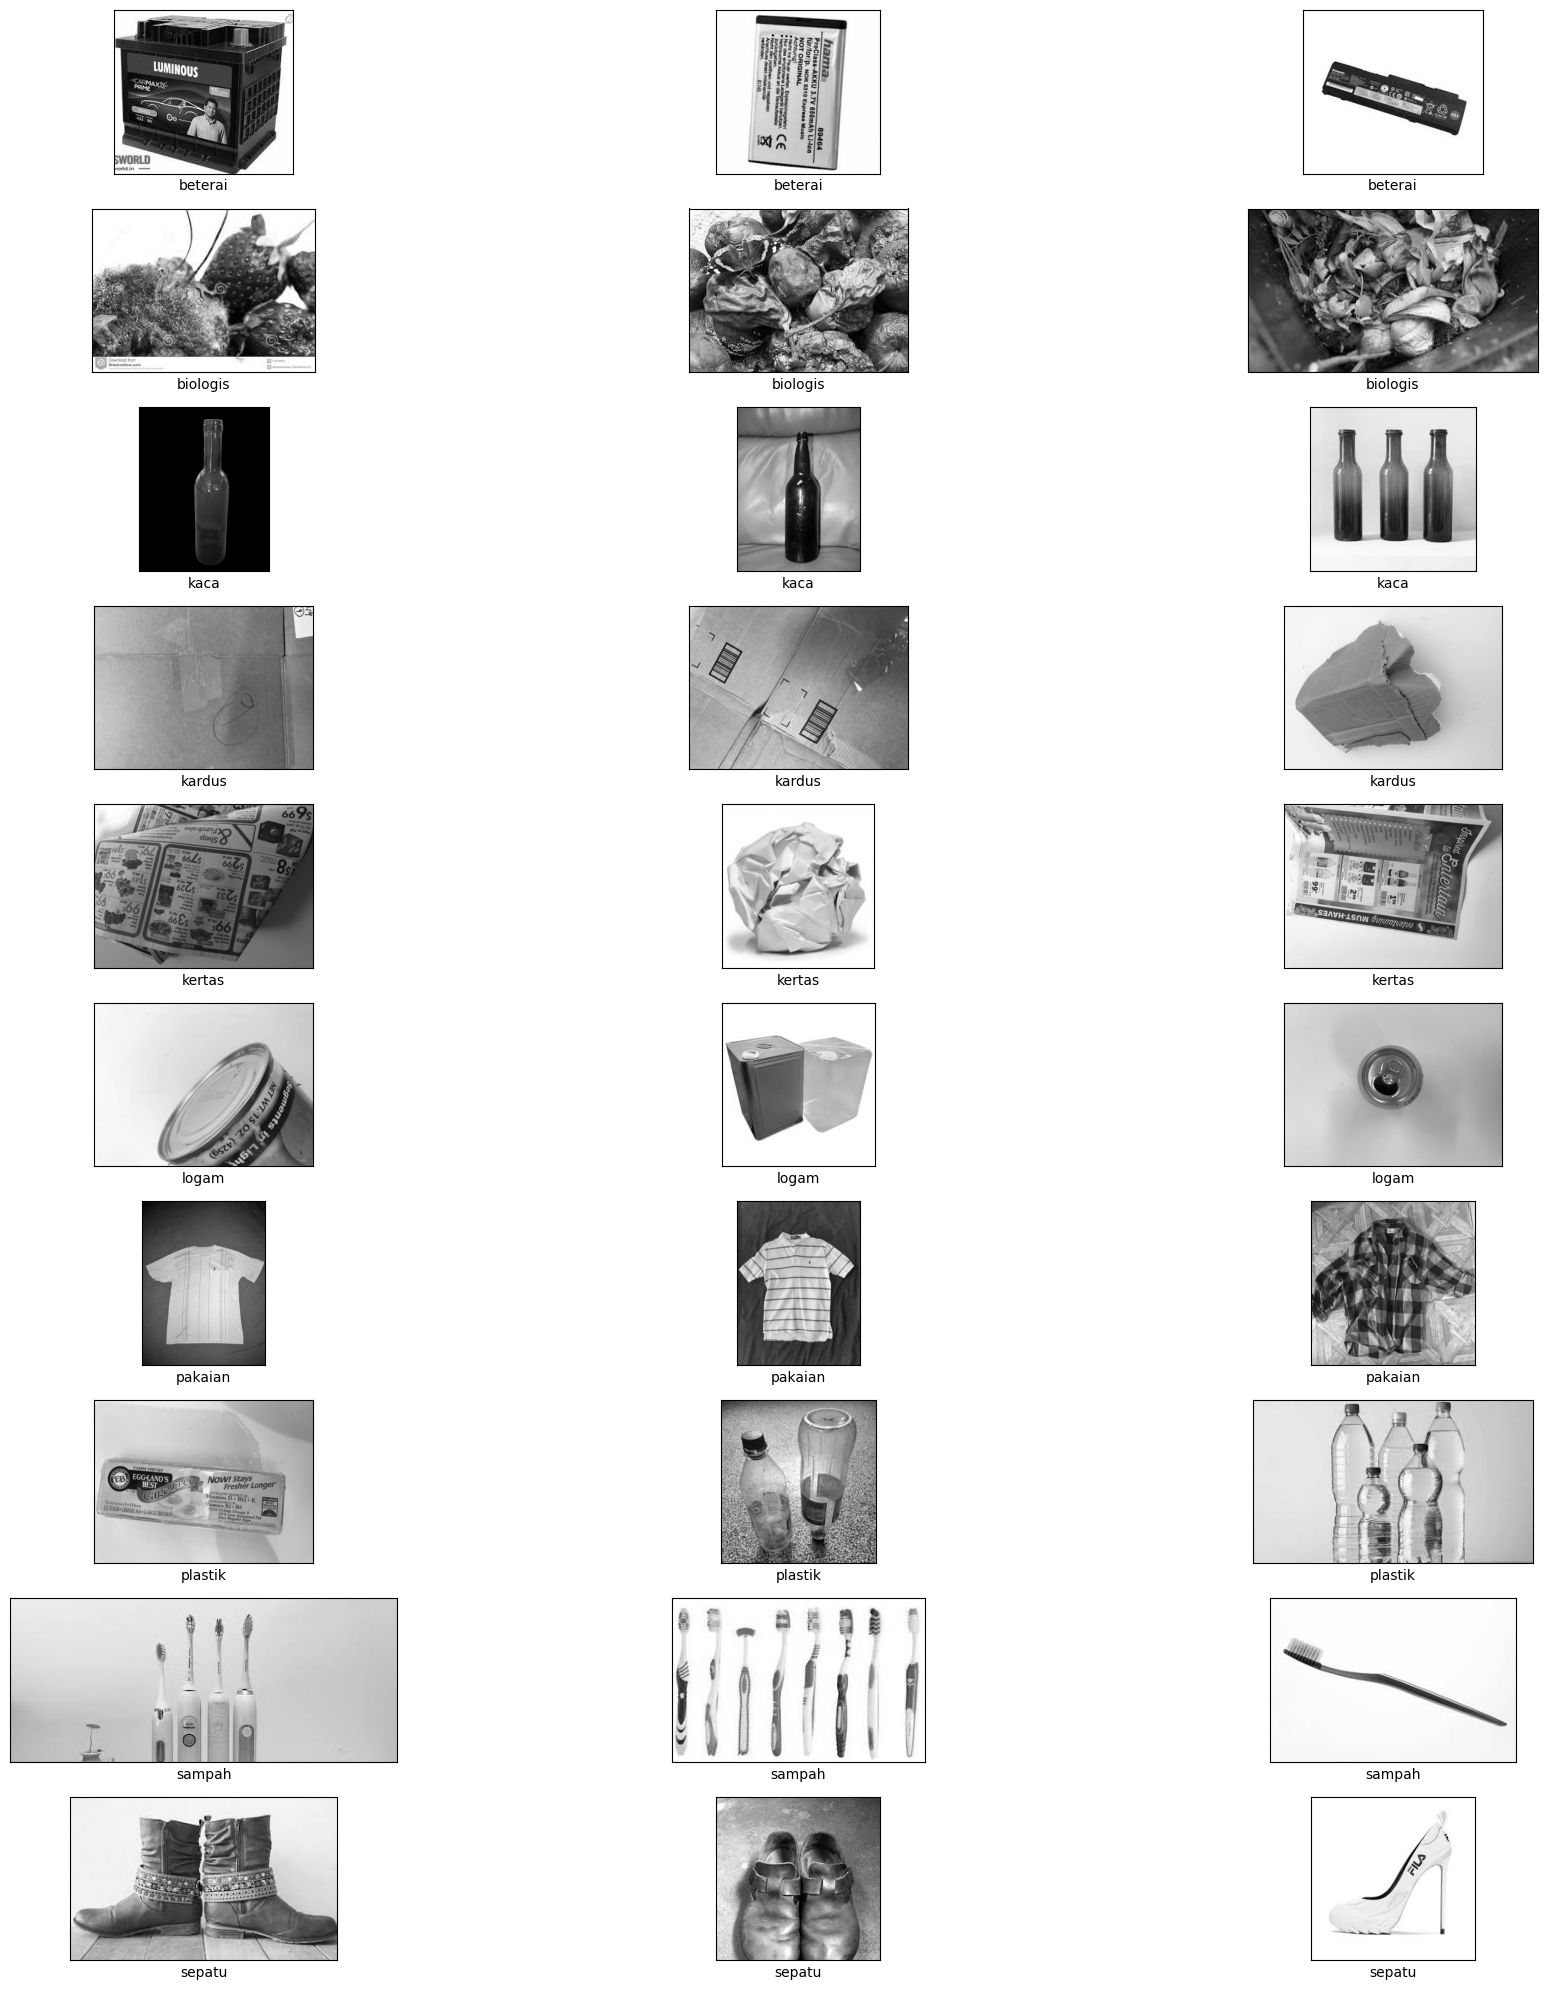

In [4]:
imgs = {}

path = "./Sampah-DataSet"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    imgs[i] = os.listdir(os.path.join(path_sub, i))

fig, axs = plt.subplots(len(imgs.keys()), 3, figsize=(20, 20))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(imgs[class_name], 3, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L") 
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

In [5]:
def print_images_resolustion(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)

        if os.path.isdir(subdir_path):
            image_files = os.listdir(subdir_path)
            num_images = len(image_files)
            print(f"{subdir} : {num_images} images")
            total_images += num_images

            for img_file in image_files:
                img_path = os.path.join(subdir_path, img_file)
                try:
                    with Image.open(img_path) as img:
                        unique_sizes.add(img.size)
                except Exception as e:
                    print(f"Error opening image : {img_path} : {e}")
        
    # print("\nUnique Image Size: ")
    # for size in unique_sizes:
    #     print(f"- {size}")

    print("-----------")
    print(f"\nTotal Images across all subdirectsories: {total_images}")

directory = "./Sampah-Dataset/dataset"
print_images_resolustion(directory)

beterai : 945 images
biologis : 985 images
kaca : 979 images
kardus : 891 images
kertas : 977 images
logam : 939 images
pakaian : 939 images
plastik : 865 images
sampah : 844 images
sepatu : 984 images
-----------

Total Images across all subdirectsories: 9348


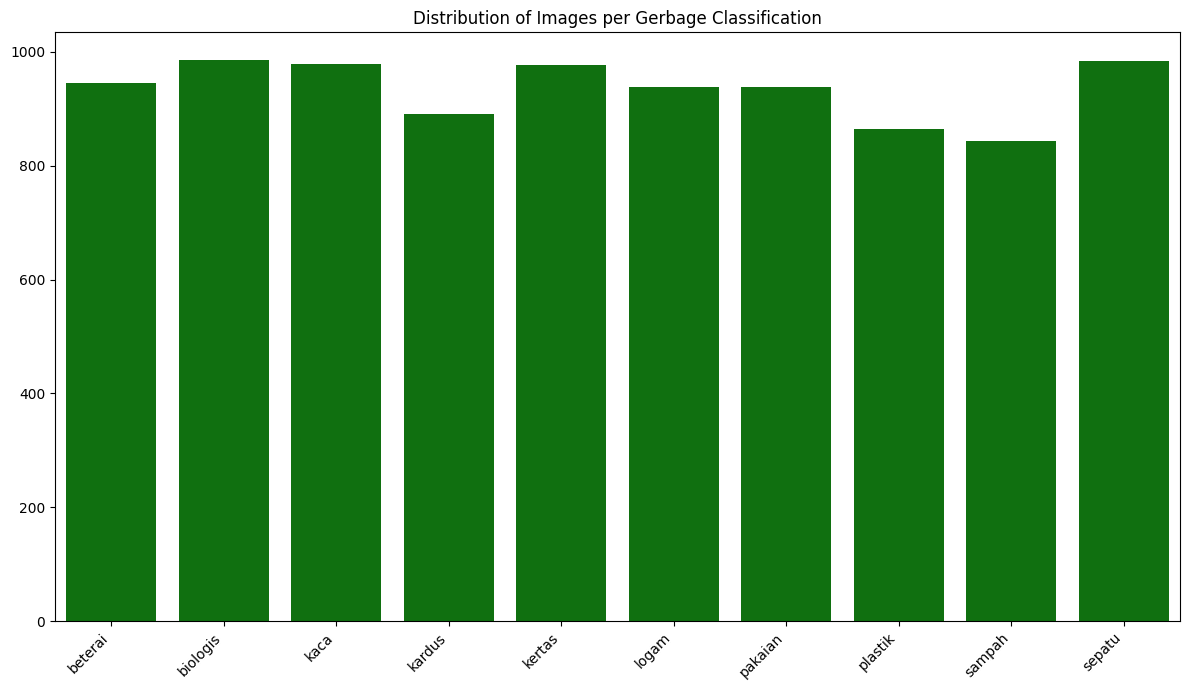

In [6]:
path = './Sampah-Dataset/dataset'

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(path):
    for name in files:
        full_path.append(os.path.join(path,name))
        labels.append(path.split('/dataset\\')[-1])
        file_name.append(name)

df = pd.DataFrame({
    "path" : full_path, 
    'file_name' : file_name,
    'labels' : labels 
})

label_counts = df.groupby('labels').size().reset_index(name = 'count')

plt.figure(figsize = (12, 7))
ax = sns.barplot(x = 'labels', y = 'count', data=label_counts, color = 'green')

plt.xticks(rotation = 45, ha = 'right')

plt.xlabel(None)
plt.ylabel(None)
plt.title('Distribution of Images per Gerbage Classification')

plt.tight_layout()
plt.show()

*PREPROCESSING*

In [7]:
image_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,  
    validation_split=0.2
)

TRAIN_DIR = "./Sampah-Dataset/dataset"
train_generator = image_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(100, 100),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)
validation_generator = image_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(100, 100),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

TRAIN_DIR_TEST = "./Sampah-Dataset/dataset-test"

test_generator = test_datagen.flow_from_directory(
    TRAIN_DIR_TEST,
    target_size = (100,100),
    batch_size = 64,
    class_mode = 'categorical',
) 


Found 7483 images belonging to 10 classes.
Found 1865 images belonging to 10 classes.
Found 3692 images belonging to 10 classes.


*MODELLING*

In [20]:
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet', include_top=False, input_shape=(100, 100, 3)
)
base_model.trainable = False 

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(10, activation='softmax')(x)  

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 50, 50,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 50, 50,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 50, 50,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 50, 50,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 50, 50,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 50, 50,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 50, 50,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 50, 50,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 50, 50,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 50, 50,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 50, 50,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 51, 51,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 25, 25,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 25, 25,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 25, 25,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 25, 25,    │      2,304 │ block_1_depthwis

 Total params: 2,430,858 (9.27 MB)

 Trainable params: 172,874 (675.29 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

for layer in base_model.layers[-30:]:  
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)
  
for layer in base_model.layers:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=7e-6),  
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune2 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

model.save("model_klasifikasi_sampah.h5")

Epoch 1/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 63s 481ms/step - accuracy: 0.1298 - loss: 2.9171 - val_accuracy: 0.3571 - val_loss: 1.9926 - learning_rate: 1.0000e-04
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 59s 504ms/step - accuracy: 0.2403 - loss: 2.1243 - val_accuracy: 0.5265 - val_loss: 1.6956 - learning_rate: 1.0000e-04
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 62s 528ms/step - accuracy: 0.3623 - loss: 1.8401 - val_accuracy: 0.5941 - val_loss: 1.4063 - learning_rate: 1.0000e-04
Epoch 4/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 59s 505ms/step - accuracy: 0.4513 - loss: 1.6125 - val_accuracy: 0.6466 - val_loss: 1.2242 - learning_rate: 1.0000e-04
Epoch 5/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 61s 519ms/step - accuracy: 0.5118 - loss: 1.4342 - val_accuracy: 0.6761 - val_loss: 1.0808 - learning_rate: 1.0000e-04
Epoch 6/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 58s 497ms/step - accuracy: 0.5397 - loss: 1.3409 - val_accuracy: 0.6922 - val_loss: 0.9823 - learning_rate: 1.0000e-04
Epoch 7/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 58s 49

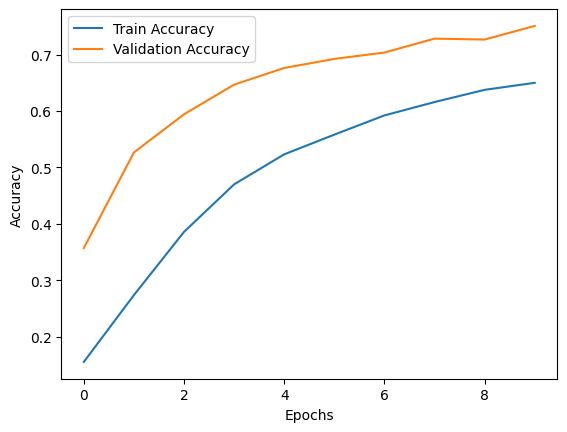

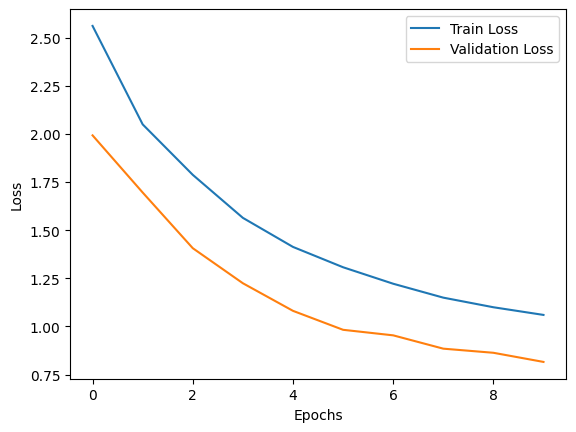

In [24]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [53]:
model = load_model("model_klasifikasi_sampah.h5")
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


58/58 ━━━━━━━━━━━━━━━━━━━━ 24s 370ms/step - accuracy: 0.8889 - loss: 0.3576
Test Accuracy: 89.44%


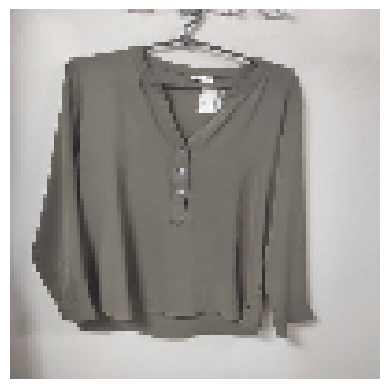

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Prediksi: pakaian (100.00%)
Label Asli: pakaian


In [69]:
import numpy as np
import random
import matplotlib.pyplot as plt

class_names = list(test_generator.class_indices.keys()) 
batch_images, batch_labels = next(test_generator)

random_idx = random.randint(0, len(batch_images) - 1)
random_image = batch_images[random_idx]  
random_label = batch_labels[random_idx]  

plt.imshow(random_image)
plt.axis("off")
plt.show()

input_image = np.expand_dims(random_image, axis=0)

prediction = model.predict(input_image)

predicted_class_idx = np.argmax(prediction)
predicted_class = class_names[predicted_class_idx]
confidence = np.max(prediction) * 100

actual_class_idx = np.argmax(random_label)
actual_class = class_names[actual_class_idx]

print(f"Prediksi: {predicted_class} ({confidence:.2f}%)")
print(f"Label Asli: {actual_class}")


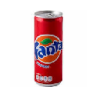

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Prediksi: logam (99.70%)


In [70]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

image_path = "Test-Image/logam-testing-1.jpeg"
image = load_img(image_path, target_size=(100, 100))  

image_array = img_to_array(image)

plt.figure(figsize=(image_array.shape[1] / 100, image_array.shape[0] / 100), dpi=100)
plt.imshow(image)
plt.axis("off")
plt.show()

input_image = np.expand_dims(image_array, axis=0) / 255.0  

prediction = model.predict(input_image)

predicted_class_idx = np.argmax(prediction)
predicted_class = class_names[predicted_class_idx]
confidence = np.max(prediction) * 100

print(f"Prediksi: {predicted_class} ({confidence:.2f}%)")


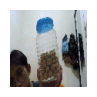

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediksi: plastik (77.27%)


In [71]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

image_path = "Test-Image/plastik-testing-1.jpg"
image = load_img(image_path, target_size=(100, 100))  

image_array = img_to_array(image)

plt.figure(figsize=(image_array.shape[1] / 100, image_array.shape[0] / 100), dpi=100)
plt.imshow(image)
plt.axis("off")
plt.show()

input_image = np.expand_dims(image_array, axis=0) / 255.0  

prediction = model.predict(input_image)

predicted_class_idx = np.argmax(prediction)
predicted_class = class_names[predicted_class_idx]
confidence = np.max(prediction) * 100

print(f"Prediksi: {predicted_class} ({confidence:.2f}%)")
